# Распараллеливание квадратурной формулы. Число pi
Железо:
-Компьютер-
Процессор		: Intel(R) Core(TM) i3-2100 CPU @ 3.10GHz
Память		: 4021 Мб (3213 Мб занято)
Тип машины		: Настольный компьютер
Операционная система		: Linux Lite 4.6
Пользователь		: main (main)
Дата/время		: Чт 06 мая 2021 13:16:27
-Дисплей-
Разрешение		: 3360x1080 пикселей
Рендер OpenGL		: GeForce GT 440/PCIe/SSE2
Поставщик X11		: The X.Org Foundation
-Аудио устройства-
Звуковая карта		: HDA-Intel - HDA Intel PCH
Звуковая карта		: HDA-Intel - HDA NVidia

Исходный код программы формулы средних прямоугольников:
```Cpp
#include <stdio.h>
#include <omp.h>

#define PI 3.14159265358

double f(double x) {
  return 1 / (1 + x * x);
}

int main(int argc, char *argv[]) {
  double pi, sum = 0, term, h, t1, t2, dt;
  int myrank, nprocs, n, i;
  if (myrank == 0) {
    printf("Number of iterations=");
    scanf("%d", &n);
  }
  h = 1.0 / n;
  omp_set_num_threads(8);
  t1 = omp_get_wtime();
#pragma omp parallel for schedule(static, n) private(i) shared(h) reduction(+:sum)
  for (i = 0; i < n; i++) {
    sum = sum + f(h * (i - 0.5));
  }

//  for (i = myrank + 1; i <= n; i += nprocs)
//    sum += f(h * (i - 0.5));
  term = 4 * h * sum;
  t2 = omp_get_wtime();
//  MPI_Reduce(&term, &pi, 1, MPI_DOUBLE, MPI_SUM, 0, MPI_COMM_WORLD);
  if (myrank == 0)
    printf("Computed fault of pi=%lf\nTime: %f\n", term - PI, t2-t1);
//  MPI_Finalize();
  return 0;
}
```

Исходный код программы формулы трапеций:
```Cpp
//
// Created by main on 06.05.2021.
//
#include <stdio.h>
#include <omp.h>

#define PI 3.14159265358

double f(double x) {
  return 1 / (1 + x * x);
}

int main(int argc, char *argv[]) {
  double pi, sum = 0, term, h, t1, t2, dt;
  int myrank, nprocs, n, i;
  if (myrank == 0) {
    printf("Number of iterations=");
    scanf("%d", &n);
  }
  h = 1.0 / n;
  omp_set_num_threads(2);
  t1 = omp_get_wtime();
#pragma omp parallel for schedule(static, n/2) private(i) shared(h) reduction(+:sum)
  for (i = 0; i < n; i++) {
    sum = sum + f(h * i);
  }

//  for (i = myrank + 1; i <= n; i += nprocs)
//    sum += f(h * (i - 0.5));
  term = 4 * h * (((f(0) - f(1))/2) + sum);
  t2 = omp_get_wtime();
//  MPI_Reduce(&term, &pi, 1, MPI_DOUBLE, MPI_SUM, 0, MPI_COMM_WORLD);
  if (myrank == 0)
    printf("pi=%f\nComputed fault of pi=%lf\nTime: %f\n", term, term - PI, t2-t1);
//  MPI_Finalize();
  return 0;
}
```

Исходный код программы формулы Симпсона:
```Cpp
//
// Created by main on 06.05.2021.
//
#include <stdio.h>
#include <omp.h>

#define PI 3.14159265358

double f(double x) {
  return 1 / (1 + x * x);
}

int main(int argc, char *argv[]) {
  double pi, sum1 = 0, sum2 = 0, term, h, t1, t2, dt;
  int myrank, nprocs, n, i;
  if (myrank == 0) {
    printf("Number of iterations=");
    scanf("%d", &n);
  }
  h = 1.0 / n;
  omp_set_num_threads(2);
  t1 = omp_get_wtime();
#pragma omp parallel for schedule(static, n/2) private(i) shared(h) reduction(+:sum1)
  for (i = 0; i < n; i++) {
    sum1 = sum1 + f(h * i);
  }
#pragma omp parallel for schedule(static, n/2) private(i) shared(h) reduction(+: sum2)
  for (i = 0; i < n + 1; i++) {
    sum2 = sum2 + f((i - 1/2)*h);
  }

//  for (i = myrank + 1; i <= n; i += nprocs)
//    sum += f(h * (i - 0.5));
  term = ((4 * h) / 3) * (((f(0) - f(1)) / 2) + 2 * sum2 + sum1);
  t2 = omp_get_wtime();
//  MPI_Reduce(&term, &pi, 1, MPI_DOUBLE, MPI_SUM, 0, MPI_COMM_WORLD);
  if (myrank == 0)
    printf("pi=%f\nComputed fault of pi=%lf\nTime: %f\n", term, term - PI, t2 - t1);
//  MPI_Finalize();
  return 0;
}
```

## Результаты работы программ
### Запуск на 2 процессах

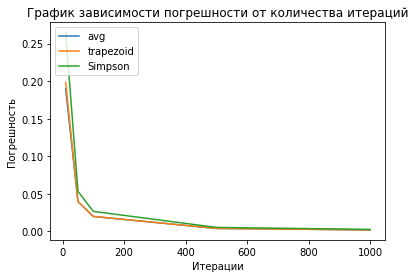

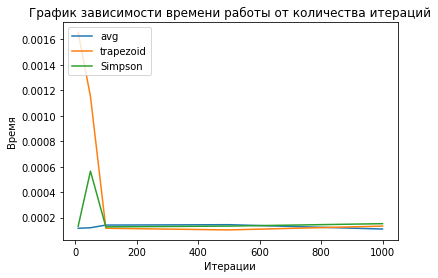

In [30]:
import numpy as np
import matplotlib.pyplot as plt

avg_fault = [0.189586, 0.039623, 0.019907, 0.003996, 0.001999]
avg_time = [0.000116, 0.000120, 0.000141, 0.000144, 0.000110]

trap_fault = [0.198333, 0.039933, 0.019983, 0.003999, 0.002000]
trap_time = [0.001654, 0.001150, 0.000116, 0.000103, 0.000133]

simpson_fault = [0.265000, 0.053267, 0.026650, 0.005333, 0.002667]
simpson_time = [0.000132, 0.000564, 0.000127, 0.000133, 0.000152]

x = [10, 50, 100, 500, 1000]
methods = ["avg", "trapezoid", "Simpson"]

plt.plot(x, avg_fault, x, trap_fault, x, simpson_fault)
plt.title('График зависимости погрешности от количества итераций')
plt.legend(methods,loc='upper left')
plt.ylabel('Погрешность')
plt.xlabel('Итерации')
plt.show()

plt.plot(x, avg_time, x, trap_time, x, simpson_time)
plt.title('График зависимости времени работы от количества итераций')
plt.legend(methods,loc='upper left')
plt.ylabel('Время')
plt.xlabel('Итерации')
plt.show()




### Запуск на 4 процессах

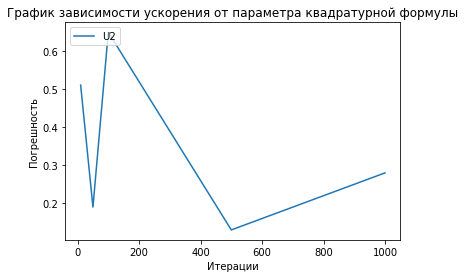

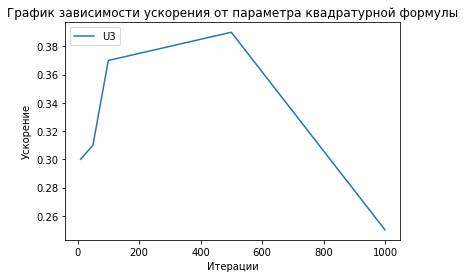

In [8]:
import numpy as np
import matplotlib.pyplot as plt

boost_u2 = [0.511, 0.19, 0.65, 0.13, 0.28]
boost_u3 = [0.3, 0.31, 0.37, 0.39, 0.25]

x = [10, 50, 100, 500, 1000]

plt.plot(x, boost_u2)
plt.title('График зависимости ускорения от параметра квадратурной формулы')
plt.legend(["U2"],loc='upper left')
plt.ylabel('Погрешность')
plt.xlabel('Итерации')
plt.show()


plt.plot(x, boost_u3)
plt.title('График зависимости ускорения от параметра квадратурной формулы')
plt.legend(["U3"],loc='upper left')
plt.ylabel('Ускорение')
plt.xlabel('Итерации')
plt.show()


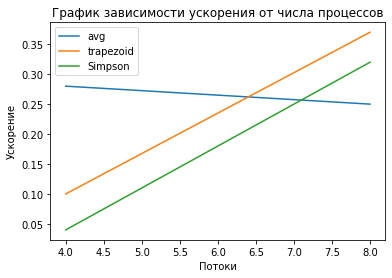

In [9]:
import numpy as np
import matplotlib.pyplot as plt

boost_u2_1 = [0.28, 0.25]
boost_u3_2 = [0.1, 0.37]
boost_u3_3 = [0.04, 0.32]
x = [4, 8]

methods = ["avg", "trapezoid", "Simpson"]

plt.plot(x, boost_u2_1, x, boost_u3_2, x, boost_u3_3)
plt.title('График зависимости ускорения от числа процессов')
plt.legend(methods,loc='upper left')
plt.ylabel('Ускорение')
plt.xlabel('Потоки')
plt.show()